## Configure the notebook

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#cd content/drive/My\ Drive/Code/Visual_Question_Answering/
cd drive/My\ Drive/Code/Visual_Question_Answering/

/content/drive/My Drive/Code/Visual_Question_Answering


In [0]:
ls

## Load the data

In [0]:
import pandas as pd

## read the csv files with the data

train_dir='./data/processed_data/DAQUAR_train_processed.csv'
test_dir='./data/processed_data/DAQUAR_test_processed.csv'

data_train=pd.read_csv(train_dir)
data_test=pd.read_csv(test_dir)

In [4]:
#lets take a look at our data 

data_train

,question,image,answer
0,['﻿what is on the right side of the black tele...,3,['desk']
1,['what is in front of the white door on the le...,3,['telephone']
2,['what is on the desk in the '],3,['book scissor papers tape_dispenser']
3,['what is the largest brown objects in this '],3,['carton']
4,['what color is the chair in front of the whit...,3,['red']
...,...,...,...
6790,['what are stuck on the wall in the '],1440,['photo']
6791,['what is in the top right corner in the '],1440,['window']
6792,['what is in front of the window in the '],1440,['cabinet']
6793,['what are the things on the cabinet in the '],1440,['candelabra book']


## Tokenization of the text

In [11]:
# Make sure that our version of tensorflow is not 2.0
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
from keras.preprocessing.text import Tokenizer

#create an instance of class Tokenizer
MAX_WORDS = 3000
tokenizer = Tokenizer(num_words = MAX_WORDS, split=' ')

#has to fit on questions and answers of the train dataset only

tokenizer.fit_on_texts(data_train['question'])
tokenizer.fit_on_texts(data_train['answer'])

1.15.0


In [0]:
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences 
import numpy as np


#the tokenizer must already be fit on your training text
def tokenization(tokenizer, length_of_sequence, dataset, multiple_answer=True):
    MAX_LEN=length_of_sequence

    seqs_question = tokenizer.texts_to_sequences(dataset['question'])
    seqs_answer = tokenizer.texts_to_sequences(dataset['answer'])

    #when you pad as 'post' you will remove the words at the end of the sentence if too long, and not at the start
    #of the sentence.
    pad_seqs_question = pad_sequences(seqs_question,MAX_LEN,truncating='post')
    pad_seqs_answer = pad_sequences(seqs_answer,MAX_LEN,truncating='post')

    #we choose if we want to keep one or multiple answers
    if multiple_answer is False:
        pad_seqs_answer_one_answer = pad_seqs_answer[:,[MAX_LEN-1]]
        return pad_seqs_question, dataset['image'], pad_seqs_answer_one_answer

    else:
        return pad_seqs_question, dataset['image'], pad_seqs_answer

In [0]:
#we set the max number of words in each questin to 25, if less than 25 there will be padding (zeros)
MAX_LEN=25

### TRAINING SET ####
train_questions,train_images,train_answers = tokenization(tokenizer, MAX_LEN, data_train, multiple_answer=False)
test_questions,test_images,test_answers = tokenization(tokenizer, MAX_LEN, data_test, multiple_answer=False)

In [0]:
import numpy as np

#this method allows us to transform our list of indices to an actual list of one hot vectors.
#this is needed only for the output of the model as the keras embedding layer can already take indices as input
def from_index_to_one_hot(index_sequence,MAX_WORDS):
  #create an empty array of size (6795, 25, 3000)
  one_hot_array=np.zeros((len(index_sequence),len(index_sequence[0]),MAX_WORDS))
  for i in range(len(index_sequence)):
    for j in range(len(index_sequence[0])):
      index = index_sequence[i,j]
      #write 1 at the location of the index
      one_hot_array[i,j,index]=1
  
  return one_hot_array

In [0]:
#max number of words in the vocabulary will be 3000, this also means that one hot encoding of words
#will be of length 3000
MAX_WORDS=3000

one_hot_array=from_index_to_one_hot(train_questions,MAX_WORDS)

## Glove words embedding

In [0]:
import numpy as np

embedding_matrix=np.load('./data/embedding/glove_300d_embedding.npy')

## Text Autoencoder

### Biredectional LSTM model with custom word embedding

In [17]:
from keras.models import Sequential
from numpy import array
from keras.models import Sequential
from keras.models import Model
from keras.layers import LSTM, GRU, Bidirectional
from keras.layers import Input
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import Embedding
from keras.layers import TimeDistributed
from keras.utils import plot_model
from keras.initializers import Constant

EMBEDDING=300
# encoder input model
inputs = Input(shape=(MAX_LEN,))
encoder1 = Embedding(MAX_WORDS,
                     EMBEDDING,
                     embeddings_initializer=Constant(embedding_matrix),
                     trainable=False)(inputs)
encoder2  = Bidirectional(LSTM(512,activation='relu'))(encoder1)
#ENCODER MODEL
#make sure to create an model inside your model. Because the encoder will be 
#saved as a model itself.
encoder_model = Model(inputs=inputs,outputs=encoder2, name='Encoder')
encoder_output=encoder_model(inputs)

# decoder output model
decoder1 = RepeatVector(MAX_LEN)(encoder_output)
decoder2= Bidirectional(LSTM(512, return_sequences=True,activation='relu'))(decoder1)
outputs = TimeDistributed(Dense(MAX_WORDS, activation='softmax'))(decoder2)

# tie it together
lstm_autoencoder_model = Model(inputs=inputs, outputs=outputs)
lstm_autoencoder_model.compile(loss='categorical_crossentropy', optimizer='adam')

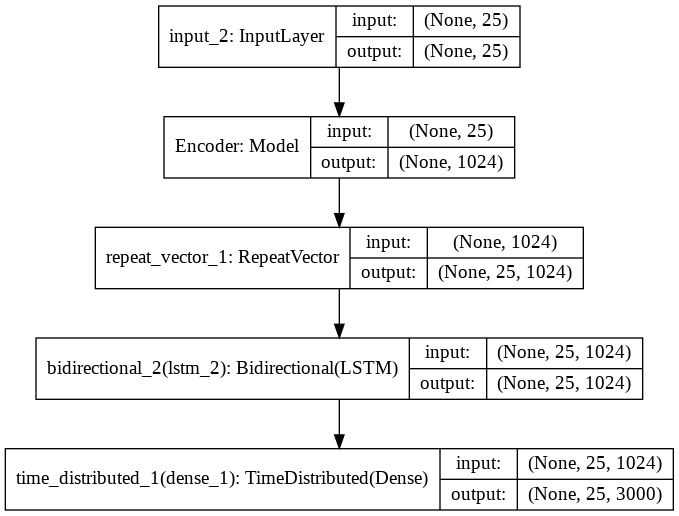

In [18]:
import os
#create a directory for the models
os.makedirs('models',exist_ok=True)

plot_model(lstm_autoencoder_model,show_layer_names=True,show_shapes=True, to_file='./models/bidirectionnal_lstm_autoencoder2.png')

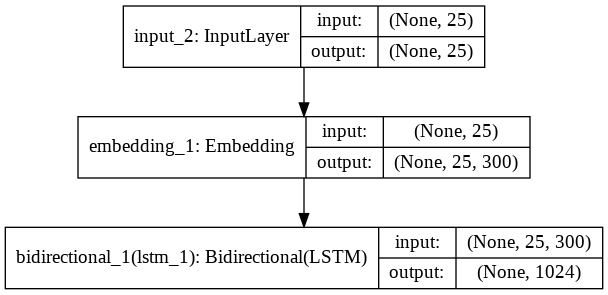

In [19]:
plot_model(encoder_model,show_layer_names=True,show_shapes=True, to_file='./models/bidirectionnal_lstm_encoder2.png')

### Training

In [20]:
from keras.callbacks import EarlyStopping

sequence = train_questions.reshape((-1, MAX_LEN))

#if the validation loss does not get new best after 5 epochs, we stop the training to avoid too much overfitting
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# fit model
history=lstm_autoencoder_model.fit(sequence,
          one_hot_array,
          batch_size=32,
          epochs=50,
          verbose=1, 
          validation_split=0.12,
          callbacks=[es]
          )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 5979 samples, validate on 816 samples
Epoch 1/50





5979/5979 [==============================] - 64s 11ms/step - loss: 1.5375 - val_loss: 0.8802
Epoch 2/50
5979/5979 [==============================] - 57s 9ms/step - loss: 0.8706 - val_loss: 0.6263
Epoch 3/50
5979/5979 [==============================] - 57s 10ms/step - loss: 0.5938 - val_loss: 0.4117
Epoch 4/50
5979/5979 [==============================] - 57s 10ms/step - loss: 0.4539 - val_loss: 0.3125
Epoch 5/50
5979/5979 [==============================] - 57s 10ms/step - loss: 0.3758 - val_loss: 0.2885
Epoch 6/50
5979/5979 [==============================] - 57s 9ms/step - loss: 0.2997 - val_loss: 0.2229
Epoch 7/50
5979/5979 [==============================] - 57s 10ms/step - loss: 0.2327 - val_loss: 0.2450
Epoch 8/50
5979/5979 [==============================] - 57s 10ms/step - loss: 0.2056 - val_loss: 0.1848
Epoch 9/50
5979/5979 

### Visualization

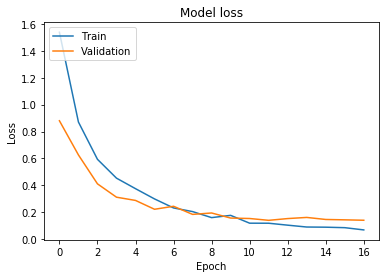

In [21]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [0]:
#save model weights

lstm_autoencoder_model.save_weights('./models/bidirectionnal_lstm_autoencoder2.h5')
encoder_model.save_weights('./models/bidirectionnal_lstm_encoder2.h5')

### Results: Compare reconstructed sentences

In [0]:
#method to get the english text back from the indices
def get_text(sentence_to_decode, tokenizer):
  reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
  sentence=[]
  for j in range(len(sentence_to_decode)):
      t=sentence_to_decode[j]
      try:
          sentence.append(reverse_word_map[t])

      except:

          pass

  return(sentence)

In [0]:
#make predicitons on the test set
decoded_predictions=lstm_autoencoder_model.predict(test_questions)
#use argmax to get the index with the highest probability
decoded_predictions_argmax=np.argmax(decoded_predictions, axis=2)

In [25]:
for index in range(20,30):
  print('')
  print('real:')
  for word in range(len(get_text(test_questions[index],tokenizer))):
    print(get_text(test_questions[index],tokenizer)[word],end=' ')
  print('')
  print('prediction:')
  for word in range(len(get_text(decoded_predictions_argmax[index],tokenizer))):
    print(get_text(decoded_predictions_argmax[index],tokenizer)[word],end=' ')


real:
'what is on the wall on the left side of the door and on the right side of the picture in the ' 
prediction:
'what 'what is on on the side side side side of the the side on the left side of the side in the ' 
real:
'what color is the door on the right side of the corridor in the ' 
prediction:
'what color is the hat on the right side of the door in the ' 
real:
'how many ceiling lamps are on in the corridor in the ' 
prediction:
'how many lamps are are on the ceiling in the ' 
real:
'what is the smallest black object on the table below the bookshelf in the ' 
prediction:
'what is the black object on the reception wall below the counter in the ' 
real:
'what is the white object on the table on the right side of the wall below the bookshelf in the ' 
prediction:
'what is the the object of the wall of the wall on the right bookshelf of the bookshelf in the ' 
real:
'what is in front of the wall on the left side of the picture in the ' 
prediction:
'what 'what is the front of the wa